In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# make dataloader
def create_dataloader(dataset_name, transform, valid=False):
    test_dl, valid_dl = None, None

    if dataset_name == 'MNIST':
        train_datasets = datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
        if valid:
            n_samples = len(train_datasets)
            train_size = int(n_samples * 0.8)
            subset1_indices = list(range(0,train_size))
            subset2_indices = list(range(train_size,n_samples))

            train_dataset = Subset(train_datasets, subset1_indices)
            valid_dataset = Subset(train_datasets, subset2_indices)

            train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
            valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
        else:
            train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    return train_dl, test_dl, valid_dl



In [21]:
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, ngf*2, bias=False),
            nn.ReLU(True),

            nn.Linear(ngf*2, ngf, bias=False),
            nn.ReLU(True),

            nn.Linear(ngf, 28*28, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        z = z.view(-1, 100)
        return self.main(z).view(-1,28,28)

class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, ndf, bias=False),
            nn.ReLU(True),

            nn.Linear(ndf, ndf*2, bias=False),
            nn.ReLU(True),

            nn.Linear(ndf*2, 1, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.main(x).squeeze()


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

EPOCH:0, iter:400, loss_D=0.876, loss_G=0.681, D(x)=0.91, D(G(z))=0.541/0.506
EPOCH:0, iter:800, loss_D=0.824, loss_G=0.675, D(x)=0.937, D(G(z))=0.529/0.51
EPOCH:0, iter:1200, loss_D=0.749, loss_G=0.764, D(x)=0.946, D(G(z))=0.498/0.467
EPOCH:1, iter:400, loss_D=1.01, loss_G=0.646, D(x)=0.851, D(G(z))=0.562/0.526
EPOCH:1, iter:800, loss_D=0.899, loss_G=0.706, D(x)=0.906, D(G(z))=0.539/0.495
EPOCH:1, iter:1200, loss_D=0.987, loss_G=0.693, D(x)=0.86, D(G(z))=0.554/0.503
EPOCH:2, iter:400, loss_D=0.992, loss_G=0.713, D(x)=0.868, D(G(z))=0.554/0.492
EPOCH:2, iter:800, loss_D=0.828, loss_G=0.793, D(x)=0.895, D(G(z))=0.507/0.454
EPOCH:2, iter:1200, loss_D=0.985, loss_G=0.636, D(x)=0.847, D(G(z))=0.551/0.53
EPOCH:3, iter:400, loss_D=0.973, loss_G=0.617, D(x)=0.882, D(G(z))=0.557/0.542
EPOCH:3, iter:800, loss_D=0.935, loss_G=0.7, D(x)=0.877, D(G(z))=0.54/0.5
EPOCH:3, iter:1200, loss_D=0.891, loss_G=0.704, D(x)=0.885, D(G(z))=0.524/0.498
EPOCH:4, iter:400, loss_D=0.978, loss_G=0.628, D(x)=0.919,

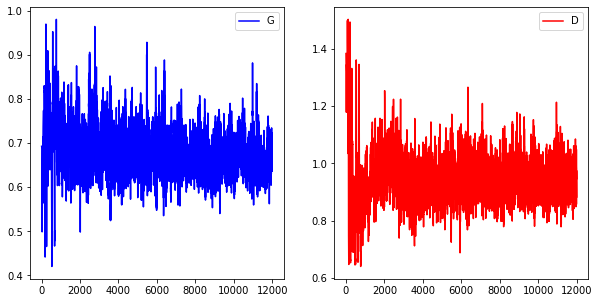

In [22]:
#GAN

# Constants
EPOCH_NUM = 10
TRAIN_BATCH_SIZE = 50
TEST_BATCH_SIZE = 8
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, _ = create_dataloader('MNIST', transform, valid=False)

nz = 100
ngf = 128
ndf = 128
netG = Generator(nz,ngf).to(device)
netG.apply(weights_init)
netD = Discriminator(ndf).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()

fixed_noise = torch.randn(8, nz, 1, 1, device=device)

optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999), amsgrad=True)
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999), amsgrad=True)

G_loss_list, D_loss_list = [], []
best_loss_G, best_loss_D = None,None

testdata, _ = next(iter(test_dl))
testdata = testdata[0].to(device)

for epoch in range(EPOCH_NUM):
    D_x, D_G_z1, D_G_z2 = 0, 0, 0
    iter_num = 0

    for datas, _ in train_dl:
        iter_num += 1

        #########################################
        netD.zero_grad()
        optim_D.zero_grad()
        real_img = datas.to(device)
        img_num = real_img.size(0)

        noise = torch.randn(img_num, nz, 1, 1, device=device)

        real_target = torch.full((img_num,), 1., device=device)
        fake_target = torch.full((img_num,), 0., device=device)

        logits_real = netD(real_img)
        loss_real = criterion(logits_real, real_target)
        D_x = logits_real.mean().item()

        fake_img = netG(noise)
        logits_fake = netD(fake_img.detach())
        loss_fake = criterion(logits_fake, fake_target)
        D_G_z1 = logits_fake.mean().item()            

        loss_D = loss_real + loss_fake
        D_loss_list.append(loss_D.item())

        loss_D.backward()
        optim_D.step()
        
        ####################################
        netG.zero_grad()
        optim_G.zero_grad()

        logits_fake_G = netD(fake_img)
        loss_G = criterion(logits_fake_G, real_target)
        D_G_z2 = logits_fake_G.mean().item()
        G_loss_list.append(loss_G.item())

        loss_G.backward()
        optim_G.step()
        
        ####################################
        if iter_num%400 == 0:
            print('EPOCH:{:}, iter:{:}, loss_D={:.3}, loss_G={:.3}, D(x)={:.3}, D(G(z))={:.3}/{:.3}'.format(epoch, iter_num, loss_D, loss_G, D_x, D_G_z1, D_G_z2))
        if epoch==0 or best_loss_D >= loss_D:
            best_loss_D = loss_D
        if epoch==0 or best_loss_G >= loss_G:
            best_loss_G = loss_G

print('Best loss_D={:.3} Best loss_G={:.3}'.format(best_loss_D, best_loss_G))

fig = plt.figure(figsize=(10.0, 5.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(G_loss_list, 'b', label='G')
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.plot(D_loss_list, 'r', label='D')
ax2.legend()
plt.show()

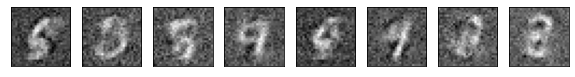

In [23]:
img = netG(fixed_noise)

fig = plt.figure(figsize=(10.0, 5.0))
for i, img in enumerate(img.cpu().detach().numpy()):
    ax = fig.add_subplot(1,8,i+1,xticks=[], yticks=[])
    ax.imshow(img, 'gray')
